In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


* Need to better document and make an interface for cache

In [2]:
import podpac
import podpac.datalib
import xarray as xr
from scipy.stats import beta as betaDist
from podpac.datalib.drought_monitor import DroughtMonitorCategory

The beta function is characterized by two parameters... which can recover from the mean and variance of that distribution.

$$\mu = \frac{1}{1+\frac{\beta}{\alpha}}$$ (1)
$$\sigma^2 = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$$ (2)

Re-arrange (1) for $\beta$
$$\beta = \alpha(\frac{1}{\mu} - 1)$$(3)

Sub (3) in (2) and solve for $\alpha$
$$\sigma^2 = \frac{\alpha^2(\frac{1}{\mu} - 1)}{(\alpha + \alpha(\frac{1}{\mu} - 1))^2(\alpha + \alpha(\frac{1}{\mu} - 1) + 1)}$$
$$\sigma^2 = \frac{\alpha^2(\frac{1}{\mu} - 1)}{(\alpha\frac{1}{\mu}))^2(\alpha\frac{1}{\mu} + 1)}$$
$$\sigma^2 = \frac{\mu^2(\frac{1}{\mu} - 1)}{(\alpha\frac{1}{\mu} + 1)}$$
$$\sigma^2 = \frac{\mu - \mu^2}{(\alpha\frac{1}{\mu} + 1)}$$
$$\alpha\frac{1}{\mu} = \frac{\mu - \mu^2}{\sigma^2} - 1$$
$$\alpha = \frac{\mu^2 - \mu^3}{\sigma^2} - \mu$$

In [3]:
cache_ctrl = podpac.core.cache.make_cache_ctrl(['ram', 'disk'])
wilt = podpac.datalib.smap.SMAPWilt(cache_ctrl=cache_ctrl)
porosity = podpac.datalib.smap.SMAPPorosity(cache_ctrl=cache_ctrl)

In [4]:
kwargs = dict(source='SPL3SMP_E.002_9km_all.nc', 
              latkey='/fakedim0', 
              lonkey='/fakedim1',
              timekey='/time',
              dims=['time', 'lat', 'lon'],
              crs='epsg:6933',
              cf_time=True,
              cf_calendar='proleptic_gregorian',
              cf_units='days since 2000-01-01',
              interpolation={
                    'default': {
                        'method': 'nearest',
                        'params': {
                            'time_tolerance': np.timedelta64(1, 'D')
                        }
                    }
                }
             )
smap_raw = podpac.data.H5PY(datakey='/Soil_Moisture_Retrieval_Data_AM_soil_moisture', **kwargs)
smap_qf = podpac.data.H5PY(datakey='/Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag', **kwargs)
smap_volumetric = podpac.algorithm.Arithmetic(A=smap_raw, B=smap_qf, eqn='((B < 1) / (B < 1)) * A ')
smap = podpac.algorithm.Arithmetic(A=smap_volumetric, B=wilt, C=porosity,
                                  eqn='(A - B) / (C - B)')

In [5]:
smap_raw.native_coordinates

Coordinates (epsg:6933)
	time: ArrayCoordinates1d(time): Bounds[2015-03-31T00:00:00.000000000, 2019-06-19T00:00:00.000000000], N[1538], ctype['point']
	lat: ArrayCoordinates1d(lat): Bounds[-1283648.5838573957, 7147891.092839261], N[937], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-16462220.8965417, -3157323.351156058], N[1478], ctype['midpoint']

In [6]:
smap_raw.native_coordinates['time'][-10:].coordinates

array(['2019-06-10T00:00:00.000000000', '2019-06-11T00:00:00.000000000',
       '2019-06-12T00:00:00.000000000', '2019-06-13T00:00:00.000000000',
       '2019-06-14T00:00:00.000000000', '2019-06-15T00:00:00.000000000',
       '2019-06-16T00:00:00.000000000', '2019-06-17T00:00:00.000000000',
       '2019-06-18T00:00:00.000000000', '2019-06-19T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [7]:
coords = smap_raw.native_coordinates[-16, 200:216, 800:816]
coords.transform('epsg:4326')

C:\Creare_Data\podpac-1.0.0\podpac\podpac\core\coordinates\dependent_coordinates.py:491: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")
C:\Creare_Data\podpac-1.0.0\podpac\podpac\core\coordinates\dependent_coordinates.py:493: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")


Coordinates (epsg:4326)
	time: ArrayCoordinates1d(time): Bounds[2019-06-04T00:00:00.000000000, 2019-06-04T00:00:00.000000000], N[1], ctype['point']
	lat,lon[lat]: DependentCoordinates(i,j->lat): Bounds[45.342995, 46.859969], shape(16, 16), ctype[midpoint]
	lat,lon[lon]: DependentCoordinates(i,j->lon): Bounds[-95.928423, -94.528008], shape(16, 16), ctype[midpoint]

In [8]:
# Cache wilt and porosity
o_w = wilt.eval(coords)
o_p = porosity.eval(coords)

In [9]:
# Expand coordinates
expand_day = podpac.algorithm.ExpandCoordinates(source=smap, 
                                                 time=['-15,D', '15,D', '1,D'])
expand_year = podpac.algorithm.ExpandCoordinates(source=expand_day, 
                                                 time=['-4,Y', '0,Y', '1,Y'])

In [10]:
expand_day.get_modified_coordinates1d(coords, 'time')

ArrayCoordinates1d(time): Bounds[2019-05-20T00:00:00.000000000, 2019-06-19T00:00:00.000000000], N[31], ctype['point']

In [11]:
c = podpac.Coordinates([expand_year.get_modified_coordinates1d(coords, 'time')], ['time'])
c

Coordinates (EPSG:4326)
	time: ArrayCoordinates1d(time): Bounds[2015-06-04T00:00:00.000000, 2019-06-04T00:00:00.000000], N[5], ctype['point']

In [12]:
expand_day.get_modified_coordinates1d(c, 'time')

ArrayCoordinates1d(time): Bounds[2015-05-20T00:00:00.000000, 2019-06-19T00:00:00.000000], N[155], ctype['point']

In [13]:
mean = podpac.algorithm.Mean(source=expand_year, dims='time', cache_ctrl=cache_ctrl)
var = podpac.algorithm.Variance(source=expand_year, dims='time', cache_ctrl=cache_ctrl)

In [14]:
o_m = mean.eval(coords)
o_s = var.eval(coords)

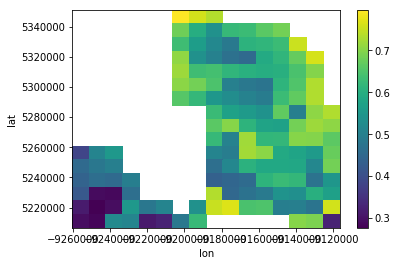

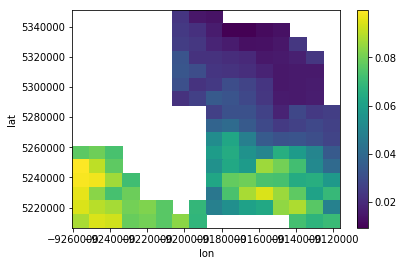

In [15]:
o_m.plot()
figure()
o_s.plot()

$$\alpha = \frac{\mu^2 - \mu^3}{\sigma^2} - \mu$$
$$\beta = \alpha(\frac{1}{\mu} - 1)$$(3)


In [16]:
alpha = podpac.algorithm.Arithmetic(A=mean, B=var, 
                                   eqn='(A**2 - A**3) / B - A',
                                   cache_ctrl=cache_ctrl)
beta = podpac.algorithm.Arithmetic(A=alpha, B=mean,
                                  eqn='A * (1 / B - 1)',
                                  cache_ctrl=cache_ctrl)

In [17]:
o_a = alpha.eval(coords)
o_b = beta.eval(coords)

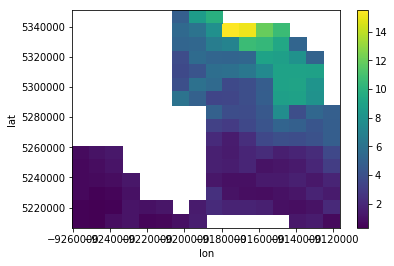

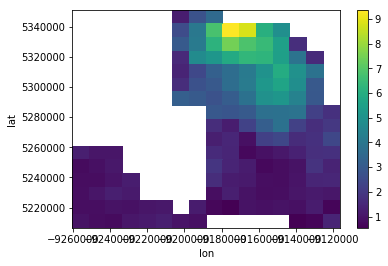

In [18]:
o_a.plot()
figure()
o_b.plot()

C:\Creare_Data\podpac-1.0.0\miniconda\envs\podpac\lib\site-packages\scipy\stats\_distn_infrastructure.py:870: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


(-0.5, 15.5, 15.5, -0.5)

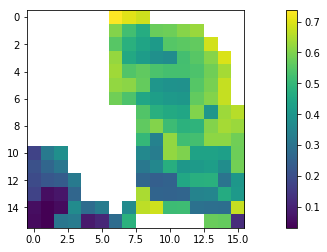

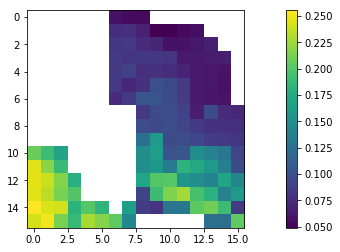

In [19]:
categories = dict(d0=0.3, d1=0.2, d2=0.1, d3=0.05, d4=0.02)
d0 = betaDist.ppf(categories['d0'], o_a, o_b)
d0_v = d0 * (o_p - o_w) + o_w
imshow(d0); colorbar(); axis('scaled'); figure()
imshow(o_m - d0); colorbar(); axis('scaled')

In [20]:
# Compare to Dara's categories
# Path used by PODPAC to retrieve the data
source = 's3://%s/%s' % ("podpac-internal-test", "drought_parameters.zarr")
d0_dara = podpac.algorithm.YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d0', source=source),
                                    year='2018', substitute_eval_coords=True)
o_d0_dara = d0_dara.eval(coords)
o_d0_dara

C:\Creare_Data\podpac-1.0.0\podpac\podpac\core\coordinates\dependent_coordinates.py:491: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")
C:\Creare_Data\podpac-1.0.0\podpac\podpac\core\coordinates\dependent_coordinates.py:493: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")


<xarray.UnitsDataArray (time: 1, lat: 16, lon: 16)>
array([[[0.3422  , 0.349631, ..., 0.363672, 0.414484],
        [0.38091 , 0.389205, ..., 0.31036 , 0.345981],
        ...,
        [0.21499 , 0.219874, ..., 0.25901 , 0.257927],
        [0.21408 , 0.206965, ..., 0.264781, 0.262047]]])
Coordinates:
  * time     (time) datetime64[ns] 2019-06-04
  * lat      (lat) float64 5.346e+06 5.337e+06 5.328e+06 ... 5.22e+06 5.211e+06
  * lon      (lon) float64 -9.256e+06 -9.247e+06 ... -9.13e+06 -9.121e+06
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x0000018807157160>
    crs:          epsg:6933

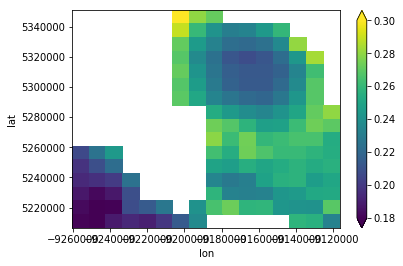

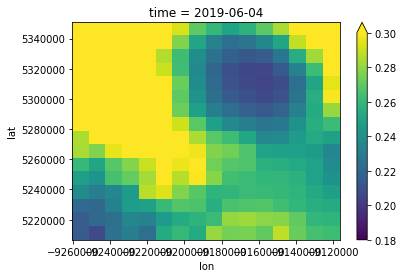

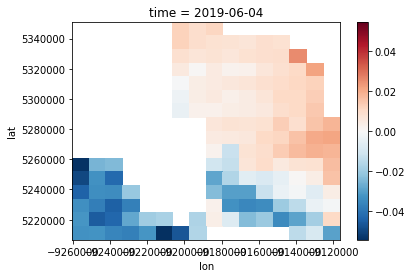

In [24]:
d0_v.plot(vmin=0.18, vmax=0.3)
figure()
o_d0_dara.plot(vmin=0.18, vmax=0.3)
figure()
(d0_v - o_d0_dara).plot()

In [21]:
# This would have been how I would have done it using xarray, but still not great
# ds.sortby(time='timedayofyear')
# w = ds.rolling(time=30, centered=True)

In [22]:
# # Let's test whether or not our fit matches Scipy's fit of the beta function
# mu = smap_node.mean()
# sigma = smap_node.var(ddof=1)

# alpha = (mu**2 - mu **3) / (sigma) - mu
# alpha

# Beta = alpha * (1 / mu - 1)
# Beta

# res = beta.fit(smap_node, floc=smap_node.min()-1e-12, fscale=smap_node.max()+1e-12)
# res

# alpha - res[0]

# Beta - res[1]

# beta.ppf(0.5, alpha, Beta)

# mu

# np.percentile(smap_node, 50)